<a href="https://colab.research.google.com/github/All4Nothing/hg-mldl/blob/main/7-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7-3 신경망 모델 훈련

# 손실 곡선

케라스의 `fit()` 메서드는 `History`클래스 객체를 반환한다.  
`History` 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [4]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

`verbose` 매개변수는 훈련 과정 출력을 조절한다. 기본값은 1로 에포크마다 진행 막대와 함께 손실 등의 지표가 출력된다.  
2로 바꾸면 진행 막대를 빼고 출력한다.  
verbose=0은 훈련 과정을 나타내지 않는다.

`history`객체에는 훈련 측정값이 담겨 있는 `history`딕셔너리가 들어 있다.  
정확도는 `compile()` 메서드에서 `metrics`매개 변수에 `accuracy`를 추가했기 때문에 history 속성에 포함되어 있다.

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


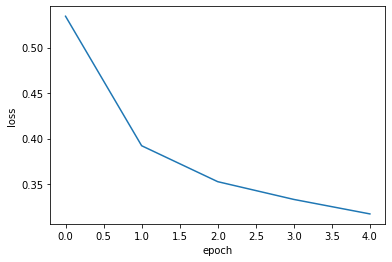

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

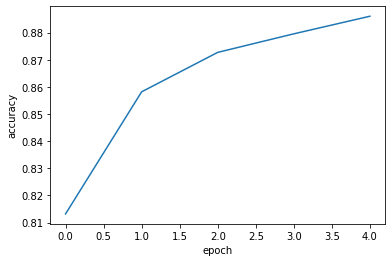

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose = 0)

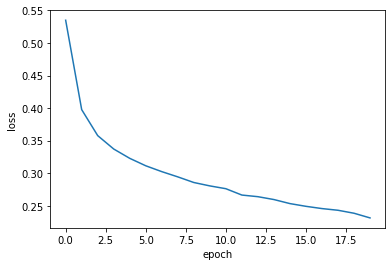

In [10]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

인공 신경망 모델이 최적화하는 대상은 정확도가 아니라 손실 함수이다. 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있따. 따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 낫다.

에포크마다 검증 손실을 계산하기 위해 케라스 모델의 `fit()` 메서드에 검증 데이터를 전달할 수 있다. `validation_data` 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


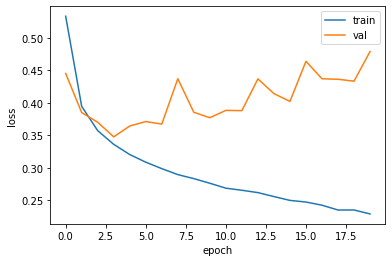

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 감소하다가 다시 상승한다. 훈련 손실은 꾸준히 감소하기 때문에 전형적이 ㄴ과대적합 모델이 만들어진다.  
검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

In [15]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

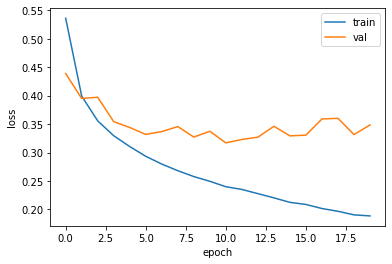

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

`Adam` 옵티마이적 이 데이터셋에 잘 맞는다는 것을 보여준다

## 드롭아웃

**드롭아웃 dropout**은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어) 과대적합을 막는다.

뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드롭할지는 또 다른 하이퍼파라미터이다.  
이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 한다.  
일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있다.

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다. 훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있다.  
텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다. 

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=2, validation_data=(val_scaled, val_target))

Epoch 1/20
1500/1500 - 4s - loss: 0.5980 - accuracy: 0.7904 - val_loss: 0.4573 - val_accuracy: 0.8312 - 4s/epoch - 2ms/step
Epoch 2/20
1500/1500 - 3s - loss: 0.4397 - accuracy: 0.8419 - val_loss: 0.3996 - val_accuracy: 0.8550 - 3s/epoch - 2ms/step
Epoch 3/20
1500/1500 - 3s - loss: 0.4034 - accuracy: 0.8542 - val_loss: 0.3669 - val_accuracy: 0.8652 - 3s/epoch - 2ms/step
Epoch 4/20
1500/1500 - 3s - loss: 0.3798 - accuracy: 0.8601 - val_loss: 0.3522 - val_accuracy: 0.8708 - 3s/epoch - 2ms/step
Epoch 5/20
1500/1500 - 3s - loss: 0.3642 - accuracy: 0.8659 - val_loss: 0.3427 - val_accuracy: 0.8766 - 3s/epoch - 2ms/step
Epoch 6/20
1500/1500 - 3s - loss: 0.3513 - accuracy: 0.8713 - val_loss: 0.3345 - val_accuracy: 0.8769 - 3s/epoch - 2ms/step
Epoch 7/20
1500/1500 - 3s - loss: 0.3417 - accuracy: 0.8749 - val_loss: 0.3451 - val_accuracy: 0.8726 - 3s/epoch - 2ms/step
Epoch 8/20
1500/1500 - 3s - loss: 0.3332 - accuracy: 0.8761 - val_loss: 0.3381 - val_accuracy: 0.8777 - 3s/epoch - 2ms/step
Epoch 9/

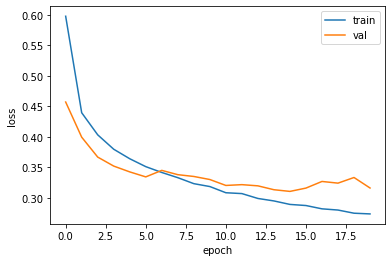

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이 모델은 20번의 에포크 동안 훈련을 했디 때문에 다소 과대적합 되어 있다. 과대적합 되지 않는 모델을 얻기 위해 에포크 횟수를 10으로 하고 다시 훈련해야 한다.

## 모델 저장과 복원

In [26]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=1, validation_data=(val_scaled, val_target))

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5907 - accuracy: 0.7917 - val_loss: 0.4272 - val_accuracy: 0.8441
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4427 - accuracy: 0.8413 - val_loss: 0.3896 - val_accuracy: 0.8583
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4060 - accuracy: 0.8539 - val_loss: 0.3572 - val_accuracy: 0.8683
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3854 - accuracy: 0.8596 - val_loss: 0.3619 - val_accuracy: 0.8680
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3687 - accuracy: 0.8644 - val_loss: 0.3459 - val_accuracy: 0.8767
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3558 - accuracy: 0.8703 - val_loss: 0.3464 - val_accuracy: 0.8745
Epoch 7/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3462 - accuracy: 0.8715 - val_loss: 0.3656 - val_accuracy:

케라스 모델은 훈련된 모델의 파라미터를 저장하는 `save_weights()` 메서드를 제공한다  
기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다


In [27]:
model.save_weights('model-weights.h5')

모델 구조와 파라미터를 함께 저장하는 `save()` 메서드도 제공한다.  
기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다

In [28]:
model.save('model-whole.h5')

In [29]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jul 19 17:44 model-weights.h5
-rw-r--r-- 1 root root 982664 Jul 19 17:45 model-whole.h5


In [30]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

케라스에서 예측을 수행하는 `predict()` 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다(패션 MNIST 데이터셋이 다중 분류 문제이기 때문)  
이진 분류 문제라면 양성 클래스에 대한 확률 하나만 반환한다.

In [31]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8746666666666667


`argmax()` 함수는 배열에서 가장 큰 값의 인덱스를 반환한다.  
`argmax()` 함수의 `axis=-1`은 배열의 마지막 차원을 따라 최댓값을 고른다. 검증 세트는 2차원 배열이기 때문에 마지막 차원은 1이 된다.  
`axis=1`이면 열을 따라 각 행의 최댓값의 인덱스를 선택하고  
`axis=0`이면 행을 따라 각 열의 최댓값의 인덱스를 선택한다.

In [35]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3361 - accuracy: 0.8747


[0.33606114983558655, 0.874666690826416]

## 콜백 

**콜백 callback**은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체이다.  
`fit()` 메서드의 `callbacks` 매개변수에 리스트로 전달하여 사용한다.

`ModelCheckpoint` 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 저장한다. 

In [37]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [38]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3176 - accuracy: 0.8895


[0.3175855278968811, 0.8895000219345093]

과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 **조기 종료 early stopping**라고 부른다.

`EarlyStopping` 콜백의 `patience` 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다.  
예를 들어 `patience=2`로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다.  
`restore_best_weight` 매개변수를 `True`로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다

In [40]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

몇 번째 에포크에서 훈련이 중지되었는지 `early_stopping_cb` 객체의 `stopped_epoch`속성에서 확인할 수 있다.

In [42]:
print(early_stopping_cb.stopped_epoch) # 에포크 횟수가 0부터 시작

10


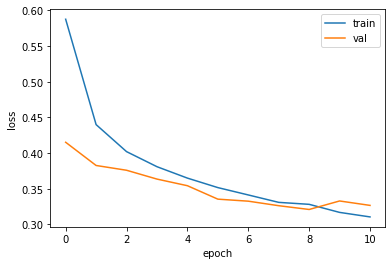

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.

In [44]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3208 - accuracy: 0.8828


[0.32082095742225647, 0.8828333616256714]